In [244]:
import pandas as pd
from math import sin, cos, sqrt, atan2, radians, floor
import datetime as dt
import knmi
import requests
import scipy.optimize
import pylab
import tqdm

import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)

In [36]:

def _calculate_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    # Approximate radius of earth in km
    radius = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    difference_lon = lon2 - lon1
    difference_lat = lat2 - lat1

    # Haversine formula
    arcsin = sin(difference_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(difference_lon / 2)**2
    haversine = 2 * atan2(sqrt(arcsin), sqrt(1 - arcsin))

    return radius * haversine

In [37]:

def _get_stationinfo() -> None:
    """Get the station positional data"""
    return pd.read_csv('measuringstations.csv')


In [44]:
def _get_closest_stations(lon:float, lat:float, N:int=3) -> pd.DataFrame:
    """Calculate the closest N stations to a given coordinate set"""

    df = _get_stationinfo()
    df['distance'] = df.apply(lambda row: _calculate_distance(lat, lon, row['LAT'], row['LON']), axis=1)
    df.sort_values('distance', inplace=True)

    return df.head(N)

## Input parameters

In [83]:
x = dt.datetime(2019,1,1)
y = dt.datetime.now()

lat, lon = 52.5012462,6.0789505

baseurl = 'https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_{0}_{1}-{2}.zip'

In [249]:
metrics = ['T', 'FH', 'DD', 'Q', 'DR', 'RH', 'N', 'U']

In [76]:
headerline = ['STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD',
       'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S',
       'O', 'Y']

In [250]:
df_closest_stations = get_closest_stations(lon, lat)

In [251]:
def get_station_weather(stn:int):
    
    df_2010s = get_station_year_weather(stn, 2011, 2020)
    df_2020s = get_station_year_weather(stn, 2021, 2030)
    
    return pd.concat([df_2010s, df_2020s])

def get_station_year_weather(stn:int, lower_year:int, upper_year:int):
    
    url = baseurl.format(stn, lower_year, upper_year)
    
    df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=headerline)
    

    for metric in metrics:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
    
    
    df['T'] = df['T'] / 10 # Temperature in decimal
    df['FH'] = df['FH'] / 10 # .. in decimal
    #df['P'] = df['P'] / 10 # Pressure in decimal
    
    return df

def get_all_station_weather(df_stations:pd.DataFrame):
    
    df = pd.DataFrame()
    
    for stn in df_closest_stations['STN'].unique():
        
        df_station = get_station_weather(stn)
        df = pd.concat([df, df_station])
        
    return df

def _fit_metric(df_for_fit:pd.DataFrame, lon:float, lat:float, metric:str) -> float:
    """Fit the windspeed for a single timestamp. 
    Requires a set of station in df_for_fit and a target location (lon, lat)"""
    
    # Model for a linear plane
    def f(X, a, b, c):
        return a*X[:,0] + b*X[:, 1] + c

    # Select the X & Y for the temperature
    x = df_for_fit[['LON', 'LAT']].values
    y = df_for_fit[metric].values

    # Do the actual fit
    popt, _ = scipy.optimize.curve_fit(f, x, y)

    # Temperature in Zwolle
    return f(np.array([[lon, lat]]), popt[0], popt[1], popt[2])

In [261]:
df_combined = get_all_station_weather(df_closest_stations)

df_combined = df_combined.loc[df_combined['YYYYMMDD'] > 20200000]

datetime_combinations = df_combined[['YYYYMMDD', 'HH']].drop_duplicates()

datetime_combinations.index = range(datetime_combinations.shape[0])

In [262]:
df_combined

,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,SQ,Q,DR,RH,P,VV,N,U,WW,IX,M,R,S,O,Y
78888,278,20200101,1,140,1.0,10,30,2.1,,21,0,0,0,0,,,NaN,100,,6,,,,,
78889,278,20200101,2,150,2.0,10,30,1.7,,17,0,0,0,0,,,NaN,100,,6,,,,,
78890,278,20200101,3,170,2.0,20,40,1.2,,12,0,0,0,0,,,NaN,100,,6,,,,,
78891,278,20200101,4,150,2.0,10,40,0.6,,6,0,0,0,0,,,NaN,100,,6,,,,,
78892,278,20200101,5,130,2.0,20,30,0.5,,5,0,0,0,0,,,NaN,100,,6,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,269,20210526,20,270,5.0,60,90,11.0,,94,0,1,0,-1,10118,70,8.0,89,22,7,0,1,0,0,0
3500,269,20210526,21,270,6.0,60,100,11.0,,96,0,0,0,-1,10120,63,8.0,91,51,7,0,1,0,0,0
3501,269,20210526,22,280,7.0,60,120,10.6,,96,0,0,9,9,10124,60,8.0,93,57,7,0,1,0,0,0
3502,269,20210526,23,280,6.0,60,110,10.1,,92,0,0,10,32,10126,61,8.0,94,61,7,0,1,0,0,0


In [263]:
df_result = pd.DataFrame()
for datetime_index in tqdm.tqdm(datetime_combinations.index):
    
    datetime_item = datetime_combinations.loc[datetime_index]
    
    m = (df_combined['YYYYMMDD'] == datetime_item['YYYYMMDD']) & (df_combined['HH'] == datetime_item['HH'])
    df_subset = pd.merge(df_combined.loc[m], df_closest_stations, on='STN')
    
    df_result_row = pd.DataFrame({'YYYYMMDD':[datetime_item['YYYYMMDD']], 
                                  'HH':[datetime_item['HH']],
                                  'datetime': dt.datetime(int(str(datetime_item['YYYYMMDD'])[:4]), 
                                                          int(str(datetime_item['YYYYMMDD'])[4:6]), 
                                                          int(str(datetime_item['YYYYMMDD'])[6:8]),
                                                          datetime_item['HH']-1,
                                                          0,
                                                          0
                                  )}
                                )

    for metric in metrics:        
        if df_subset[metric].dropna().shape[0] == 3:
            df_result_row[metric] = _fit_metric(df_subset, lon, lat, metric)
        
    df_result = pd.concat([df_result, df_result_row])
    
    
    
    
df_result

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12288/12288 [06:25<00:00, 31.89it/s]


,YYYYMMDD,HH,datetime,T,FH,DD,Q,DR,RH,U
0,20200101,1,2020-01-01 00:00:00,2.179416,1.236466,144.461585,7.139165e-318,7.139165e-318,7.139165e-318,99.402142
0,20200101,2,2020-01-01 01:00:00,1.654490,2.000000,144.869076,7.139165e-318,7.139165e-318,7.139165e-318,99.402142
0,20200101,3,2020-01-01 02:00:00,1.290570,2.124926,165.270680,7.139165e-318,7.139165e-318,7.139165e-318,99.638608
0,20200101,4,2020-01-01 03:00:00,0.933730,2.361392,148.884604,7.139165e-318,7.139165e-318,7.139165e-318,99.638608
0,20200101,5,2020-01-01 04:00:00,0.823914,2.361392,138.477112,7.139165e-318,7.139165e-318,7.139165e-318,99.277215
...,...,...,...,...,...,...,...,...,...,...
0,20210526,20,2021-05-26 19:00:00,10.609756,4.361392,272.364660,1.000000e+00,7.473521e+00,3.044017e+00,91.625221
0,20210526,21,2021-05-26 20:00:00,10.434742,4.249853,265.978584,7.139165e-318,8.750736e+00,8.577620e+00,94.500294
0,20210526,22,2021-05-26 21:00:00,10.401339,4.847711,275.978584,7.139165e-318,9.875074e+00,2.023438e+01,93.875074
0,20210526,23,2021-05-26 22:00:00,10.140214,4.722785,282.364660,7.139165e-318,1.000000e+01,1.738431e+01,94.000000


<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'T')

<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'FH')

<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'DD')

<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'Q')

<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'DR')

<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'RH')

<AxesSubplot:xlabel='datetime'>

Text(0.5, 1.0, 'U')

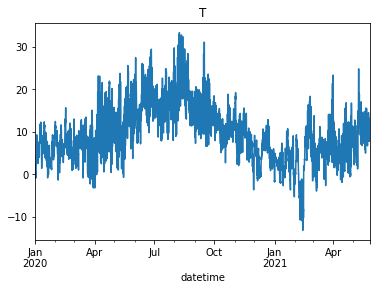

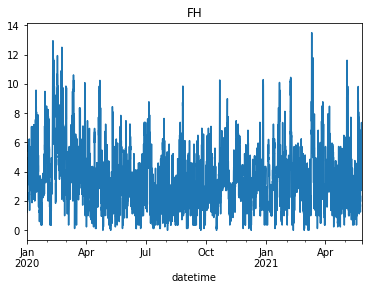

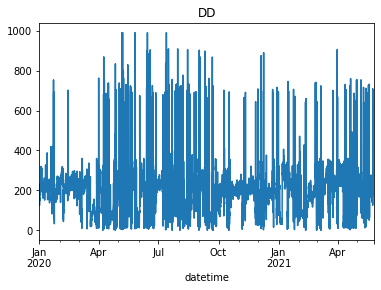

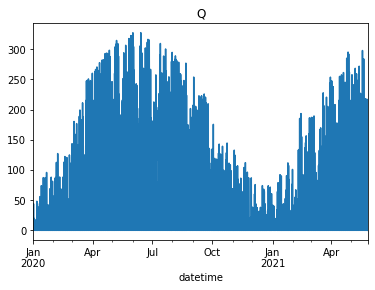

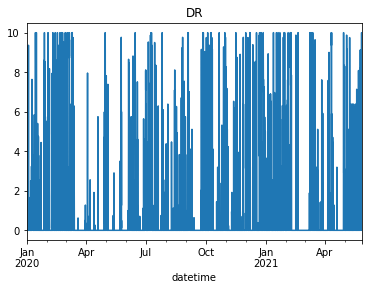

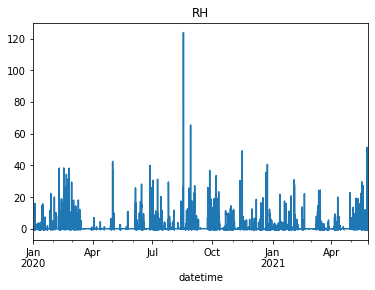

<Figure size 432x288 with 0 Axes>

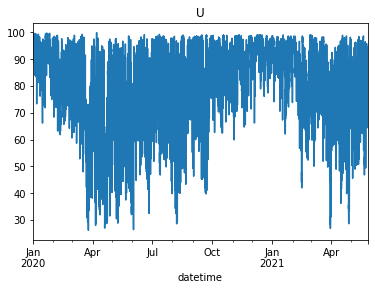

In [264]:
for metric in metrics: 
    fig = pylab.figure();
    
    try:
        df_result.set_index('datetime')[metric].plot();
        pylab.title(metric);
    except:
        pass